<a href="https://colab.research.google.com/github/aakriti1kumar/Psych237-ScalarEstimation/blob/main/237_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pystan
import pystan
!pip install arviz
import arviz as az
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, bernoulli
import math
from scipy.special import btdtri, logit, softmax

Data

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/aakriti1kumar/Psych237-ScalarEstimation/main/crone_data.csv")
df = df[df['Experiment']=='crone1']
I=int(len(df['UserID'].unique()))
J = int(len(df['UserID'])/I)
N = I*J
y = df['Response']
theta = df['Question']

Look at outliers

In [6]:
y[y>200]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


321     300
399     201
2654    356
3511    250
3512    260
3531    580
3533    250
3692    320
Name: Response, dtype: int64

In [8]:
y[y<20]

183     18
186     17
300     12
345      7
364      7
386      7
451      5
732     15
752     15
826      6
1221     4
1512    19
1528    19
1558    19
1929     6
2000     6
2031    12
2042     4
2678     6
2687     8
2844    19
2952    15
3063    12
3193     0
3277     5
3669    15
3670     2
3671     3
3675    15
3680    15
3681    15
3682    15
3683    15
3694    15
3709    15
Name: Response, dtype: int64

Baseline 1: Mean

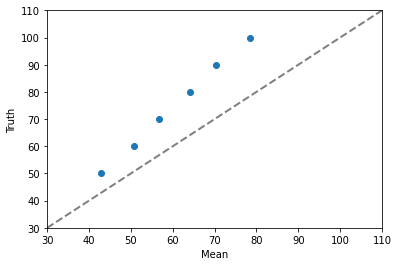

In [9]:
mean_response = []
for i in [50,60,70,80,90,100]:
  mean_response.append(y[theta==i].mean())

plt.scatter(mean_response,[50,60,70,80,90,100])
plt.xlabel("Mean")
plt.ylabel("Truth")
plt.xlim(30,110)
plt.ylim(30,110)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


Baseline 2: Median

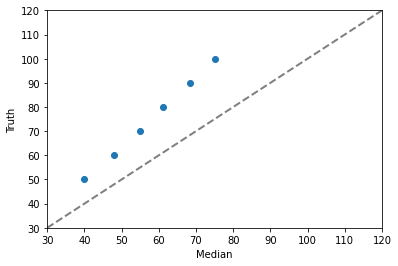

In [10]:
median_response = []
for i in [50,60,70,80,90,100]:
  median_response.append(y[theta==i].median())

plt.scatter(median_response,[50,60,70,80,90,100])
plt.xlabel("Median")
plt.ylabel("Truth")
plt.xlim(30,120)
plt.ylim(30,120)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


RMSE for each question

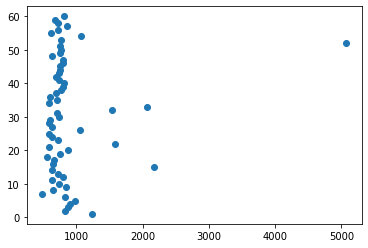

In [11]:
#63 participants, 60 trials each
#RMSE for each question
y_matrix = np.asmatrix(y.values.reshape(I,J))
theta_matrix = np.asmatrix(theta.values.reshape(I,J))
RMSE = np.square(y.values.reshape(I,J) - theta.values.reshape(I,J)).mean(axis =0)
RMSE = RMSE.tolist()
plt.scatter(RMSE, np.linspace(1,60,60))

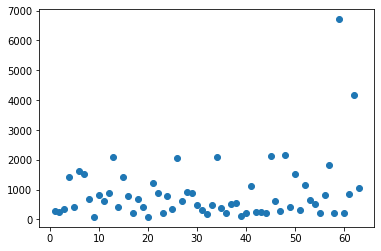

In [ ]:
WOC = np.square(y.values.reshape(I,J) - theta.values.reshape(I,J)).mean(axis =1)
plt.scatter(np.linspace(1,63,63), WOC)

Simple Model - Exchangeable participants

In [18]:
#No people, N questions

model1 = """
data {
  int<lower=0> N; //Number of questions
  real y[N];
}
parameters{
  real<lower=0> psi;
  real<lower=0> mu;
}
model{
  target += normal_lpdf(psi | 0, 5);       // prior log-density
  target += normal_lpdf(mu | 75, 25); //
  target += normal_lpdf(y | mu, psi); // log-likelihood
}
"""

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d56749921de37503e552ce9219ab52d9 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d56749921de37503e552ce9219ab52d9 NOW.


[42.94804185342009]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d56749921de37503e552ce9219ab52d9 NOW.


[42.94804185342009, 50.73208075532183]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d56749921de37503e552ce9219ab52d9 NOW.


[42.94804185342009, 50.73208075532183, 56.76361906619385]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d56749921de37503e552ce9219ab52d9 NOW.


[42.94804185342009, 50.73208075532183, 56.76361906619385, 64.01640550927355]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d56749921de37503e552ce9219ab52d9 NOW.


[42.94804185342009, 50.73208075532183, 56.76361906619385, 64.01640550927355, 70.37357944515193]
[42.94804185342009, 50.73208075532183, 56.76361906619385, 64.01640550927355, 70.37357944515193, 78.56320773400836]


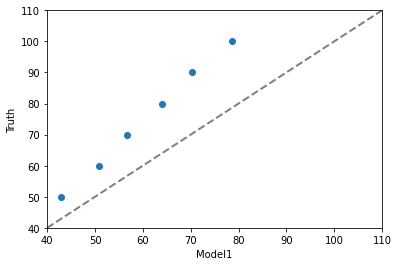

In [19]:
model1_response = []
for value in [50,60,70,80,90,100]:
  data_model1= {"N":I*10, "y":y[theta==value]}
  fit = pystan.stan(model_code=model1, data=data_model1, iter=1000, chains=4)
  model1_response.append(fit['mu'].mean())
  print(model1_response)


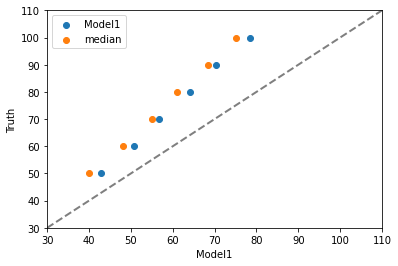

In [21]:
plt.scatter(model1_response,[50,60,70,80,90,100], label = "Model1")
plt.scatter(median_response,[50,60,70,80,90,100], label = "median")
plt.xlabel("Model1")
plt.ylabel("Truth")
plt.xlim(30,110)
plt.ylim(30,110)
xpoints = ypoints = plt.xlim()
plt.legend()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


Model 2: Merkle Saw Stober Model

In [45]:
#I people, J questions

model2_code = """
data {
  int<lower=0> I; //Number of people
  int<lower=0> J; //Number of questions
  matrix<lower=0>[I,J] y; //response of person i on question j
}
parameters{
  vector<lower=0>[I] psi; 
  vector<lower=0>[I] lambda;
  real<lower=0> theta;
}
transformed parameters{
  matrix<lower=0>[I,J] mu;
  for(i in 1:I)
    for(j in 1:J)
      mu[i,j] = lambda[i]*theta;
}
model{
  psi ~ cauchy(0,1);
  lambda ~ normal(1, .2);
  theta ~ normal(75,10);
  for(i in 1:I)
    for(j in 1:J){
      y[i,j] ~ normal(mu[i,j], psi[i]);
      }
}
"""

In [46]:
model2_theta = []
for i in [50,60,70,80,90,100]:
  stim = y[theta==i].values
  data_model2  = {"I":I, "J": 10,"y":stim.reshape(I,10)}
  model2 = pystan.StanModel(model_code=model2_code)
  fit_model2 = model2.sampling(data=data_model2, chains=4, seed=111)
  model2_theta.append(fit_model2['theta'].mean())
  print(fit_model2['lambda'].mean())
  print(fit_model2['theta'].mean())




INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1146095350da4fb0a7662e08d18a9d70 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1146095350da4fb0a7662e08d18a9d70 NOW.


0.9636907332358056
43.44249933924166


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1146095350da4fb0a7662e08d18a9d70 NOW.


0.9641292318299768
50.69023923085313


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1146095350da4fb0a7662e08d18a9d70 NOW.


0.977553086851483
56.77555090121882


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1146095350da4fb0a7662e08d18a9d70 NOW.


0.9644250840523927
65.33791912561182


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1146095350da4fb0a7662e08d18a9d70 NOW.


0.9658874101139063
71.69704087967916
0.9627807568576298
79.82200435172773


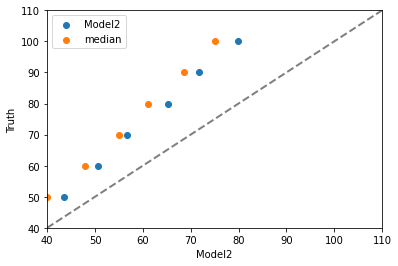

In [47]:
plt.scatter(model2_theta,[50,60,70,80,90,100], label = "Model2")
plt.scatter(median_response,[50,60,70,80,90,100], label = "median")
plt.xlabel("Model2")
plt.ylabel("Truth")
plt.xlim(40,110)
plt.ylim(40,110)
xpoints = ypoints = plt.xlim()
plt.legend()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


Model 3: Merkle Saw Stober with delta

In [42]:
#I people, J questions

model3_code = """
data {
  int<lower=0> I; //Number of people
  int<lower=0> J; //Number of questions
  matrix<lower=0>[I,J] y; //response of person i on question j
}
parameters{
  vector<lower=0>[I] psi; 
  vector<lower=0>[I] lambda;
  real<lower=0> delta[I];
  real<lower=0> theta;
}
transformed parameters{
  matrix<lower=0>[I,J] mu;
  for(i in 1:I)
    for(j in 1:J)
      mu[i,j] = lambda[i]*theta + delta[i];
}
model{
  psi ~ gamma(2,2);
  lambda ~ gamma(1, 1);
  theta ~ normal(75,10);
  delta ~ normal(0,3);
  for(i in 1:I)
    for(j in 1:J){
      y[i,j] ~ normal(mu[i,j], psi[i]);
      }
}
"""


In [43]:
model3_theta = []
for i in [50,60,70,80,90,100]:
  stim = y[theta==i].values
  data_model3  = {"I":I, "J": 10,"y":stim.reshape(I,10)}
  model3 = pystan.StanModel(model_code=model3_code)
  fit_model3 = model3.sampling(data=data_model3, chains=4, seed=111)
  model3_theta.append(fit_model3['theta'].mean())
  print(fit_model3['theta'].mean())




INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c80393950f64ce2b962141903451e4 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c80393950f64ce2b962141903451e4 NOW.


52.10162211249217


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c80393950f64ce2b962141903451e4 NOW.


58.335456507628145


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c80393950f64ce2b962141903451e4 NOW.


62.59936702465319


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c80393950f64ce2b962141903451e4 NOW.


67.60809203344388


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c80393950f64ce2b962141903451e4 NOW.


72.61347924014476


75.64806659810777


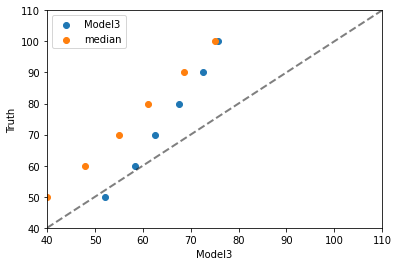

In [44]:
plt.scatter(model3_theta,[50,60,70,80,90,100], label = "Model3")
plt.scatter(median_response,[50,60,70,80,90,100], label = "median")
plt.xlabel("Model3")
plt.ylabel("Truth")
plt.xlim(40,110)
plt.ylim(40,110)
xpoints = ypoints = plt.xlim()
plt.legend()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


In [ ]:
#I people, J questions

model4_code = """
data {
  int<lower=0> I; //Number of people
  int<lower=0> J; //Number of questions
  matrix<lower=0>[I,J] y; //response of person i on question j
}
parameters{
  real<lower=0> psisq; 
  vector<lower=0>[I] lambda;
  real<lower=0> theta;
}
transformed parameters{
  real<lower=0> psi;
  vector<lower=0>[I] mu;
  for(i in 1:I)
    mu[i] = lambda[i]*theta;
  psi = sqrt(psisq);
}
model{
  psisq ~ inv_gamma(1,1);
  lambda ~ normal(1, .2);
  theta ~ normal(75,30);
  for(i in 1:I)
    y[i] ~ normal(mu[i], psi);
}
"""

In [ ]:
model4_theta = []
for i in [50,60,70,80,90,100]:
  stim = y[theta==i].values.reshape(I,10)
  data_model4  = {"I":I, "J":10, "y":stim}
  model4 = pystan.StanModel(model_code=model4_code)
  fit_model4 = model4.sampling(data=data_model4, chains=4, seed=111)
  model4_theta.append(fit_model4['theta'].mean())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdb9d3796158169ee87bed8a9bcd377b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdb9d3796158169ee87bed8a9bcd377b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdb9d3796158169ee87bed8a9bcd377b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdb9d3796158169ee87bed8a9bcd377b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdb9d3796158169ee87bed8a9bcd377b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdb9d3796158169ee87bed8a9bcd377b NOW.


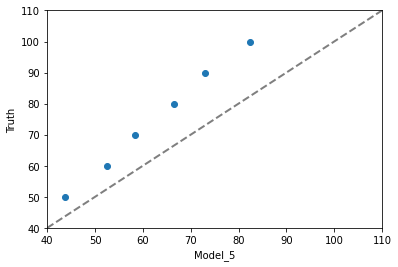

In [ ]:
plt.scatter(model4_theta,[50,60,70,80,90,100], label = "Model4")
plt.scatter(median_response,[50,60,70,80,90,100], label = "median")
plt.xlabel("Model4")
plt.ylabel("Truth")
plt.xlim(40,110)
plt.ylim(40,110)
xpoints = ypoints = plt.xlim()
plt.legend()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


In [48]:
#I people, J questions

model8_code = """
data {
  int<lower=0> I; //Number of people
  int<lower=0> J; //Number of questions
  matrix<lower=0>[I,J] y; //response of person i on question j
}
parameters{
  real<lower=0> psisq; 
  vector<lower=0>[I] lambda; 
  real<lower=0> theta;
}
transformed parameters{
  real<lower=0> psi;
  vector<lower=0>[I] mu;
  for(i in 1:I)
    mu[i] = lambda[i]*log(theta);
  psi = sqrt(psisq);
}
model{
  psisq ~ inv_gamma(1,1);
  lambda ~ normal(10, 5);
  theta ~ normal(75,30);
  for(i in 1:I)
    y[i] ~ normal(mu[i], psi);
}
"""


# target += normal_lpdf(psi | 0, 1);       // prior log-density
# target += normal_lpdf(lambda | 0, 1);       // prior log-density
# target += normal_lpdf(delta | 0, 1);       // prior log-density
# target += normal_lpdf(y | mu, psi); // log-likelihood 

In [49]:
model8_theta = []
for i in [50,60,70,80,90,100]:
  stim = y[theta==i].values.reshape(I,10)
  data_model8  = {"I":I, "J":10, "y":stim}
  model8 = pystan.StanModel(model_code=model8_code)
  fit_model8 = model8.sampling(data=data_model8, chains=4, seed=111)
  model8_theta.append(fit_model8['theta'].mean())
  print(fit_model8['theta'].mean())



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2ceb3a2387fe437e981fcc27e57adef NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2ceb3a2387fe437e981fcc27e57adef NOW.


50.601485965334724


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2ceb3a2387fe437e981fcc27e57adef NOW.


92.03058323814574


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2ceb3a2387fe437e981fcc27e57adef NOW.


118.00071426698534


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2ceb3a2387fe437e981fcc27e57adef NOW.


150.75230086505434


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2ceb3a2387fe437e981fcc27e57adef NOW.


175.5444780850134
207.95248566361536


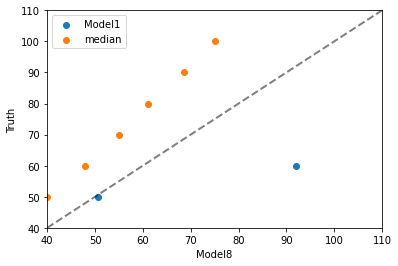

In [50]:
plt.scatter(model8_theta,[50,60,70,80,90,100], label = "Model1")
plt.scatter(median_response,[50,60,70,80,90,100], label = "median")
plt.xlabel("Model8")
plt.ylabel("Truth")
plt.xlim(40,110)
plt.ylim(40,110)
xpoints = ypoints = plt.xlim()
plt.legend()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


In [ ]:
#I people, J questions

model9_code = """
data {
  int N;
  vector<lower=0>[N] y; //response of person i on question j
}
parameters{
  real<lower=0> psisq; 
  real<lower=0> lambda; 
  real<lower=0> theta;
}
transformed parameters{
  real<lower=0> psi;
  real<lower=0> mu;
  mu = lambda*log(theta);
  psi = sqrt(psisq);
}
model{
  psisq ~ inv_gamma(1,1);
  lambda ~ normal(10, 5);
  theta ~ normal(75,30);
  y ~ normal(mu, psi);
}
"""


# target += normal_lpdf(psi | 0, 1);       // prior log-density
# target += normal_lpdf(lambda | 0, 1);       // prior log-density
# target += normal_lpdf(delta | 0, 1);       // prior log-density
# target += normal_lpdf(y | mu, psi); // log-likelihood 

In [ ]:
model9_theta = []
for i in [50,60,70,80,90,100]:
  stim = y[theta==i].values
  data_model9  = {"N":I*10, "y":stim}
  model9 = pystan.StanModel(model_code=model9_code)
  fit_model9 = model9.sampling(data=data_model9, chains=4, seed=111)
  model9_theta.append(fit_model9['theta'].mean())
  print(fit_model9['lambda'].mean())
  print(fit_model9['theta'].mean())
  print(fit_model9['psi'].mean())
  print(fit_model9['mu'].mean())



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8868383e95bde491fc9564ecd715c886 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8868383e95bde491fc9564ecd715c886 NOW.


10.275966205040428
74.84276746106018
22.868731942000426
42.88590841463425


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8868383e95bde491fc9564ecd715c886 NOW.


11.98445213416541
77.05058813547751
27.56626053121921
50.65815595275166


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8868383e95bde491fc9564ecd715c886 NOW.


13.290982510045982
79.15226879272731
22.42415472468755
56.71385499052552


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8868383e95bde491fc9564ecd715c886 NOW.


14.716149344417904
83.99034128589604
23.65123852691026
63.99053499142108


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8868383e95bde491fc9564ecd715c886 NOW.


16.1292263797982
84.29210937687171
26.26884096215719
70.26380477160646
17.74034752534639
88.89788444766198
29.95687411161317
78.42863789999468


In [ ]:
model9_theta

[74.84276746106018,
 77.05058813547751,
 79.15226879272731,
 83.99034128589604,
 84.29210937687171,
 88.89788444766198]

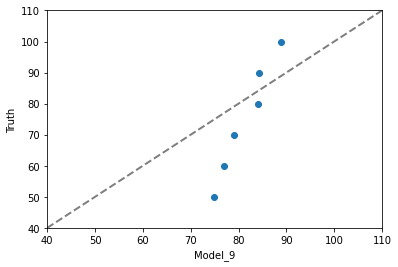

In [ ]:
plt.scatter(model9_theta,[50,60,70,80,90,100])
plt.xlabel("Model_9")
plt.ylabel("Truth")
plt.xlim(40,110)
plt.ylim(40,110)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


In [ ]:
#I people, J questions

model10_code = """
data {
  int N;
  vector<lower=0>[N] y; //response of person i on question j
}
parameters{
  real<lower=0> psisq; 
  real<lower=0> lambda; 
  real<lower=0> theta;
  real<lower=0> delta;
}
transformed parameters{
  real<lower=0> psi;
  real<lower=0> mu;
  mu = lambda*log(theta) + delta;
  psi = sqrt(psisq);
}
model{
  delta ~ normal(0,10);
  psisq ~ inv_gamma(1,1);
  lambda ~ normal(10, 5);
  theta ~ normal(75,30);
  y ~ normal(mu, psi);
}
"""


# target += normal_lpdf(psi | 0, 1);       // prior log-density
# target += normal_lpdf(lambda | 0, 1);       // prior log-density
# target += normal_lpdf(delta | 0, 1);       // prior log-density
# target += normal_lpdf(y | mu, psi); // log-likelihood 

In [ ]:
model10_theta = []
for i in [50,60,70,80,90,100]:
  stim = y[theta==i].values
  data_model10  = {"N":I*10, "y":stim}
  model10 = pystan.StanModel(model_code=model10_code)
  fit_model10 = model10.sampling(data=data_model10, chains=4, seed=111)
  model10_theta.append(fit_model10['theta'].mean())
  print(fit_model10['lambda'].mean())
  print(fit_model10['theta'].mean())
  print(fit_model10['psi'].mean())
  print(fit_model10['mu'].mean())



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96260718f885f3064328c0c362bf310e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96260718f885f3064328c0c362bf310e NOW.


8.77688049654834
70.34512728113343
22.88873412973014
42.91044465893035


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96260718f885f3064328c0c362bf310e NOW.


10.314781435315197
73.63470813107563
27.598624651661165
50.681416498043575


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96260718f885f3064328c0c362bf310e NOW.


11.495245528561725
75.26837296965167
22.38729248735213
56.69578485887787


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96260718f885f3064328c0c362bf310e NOW.


12.97655729274673
78.99352341882366
23.676792899049847
64.01050173569679


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96260718f885f3064328c0c362bf310e NOW.


14.21458743703222
81.07923220345971
26.269755891096704
70.3009984725458


15.82481429603836
84.82964834967764
29.970490184814143
78.47516523888


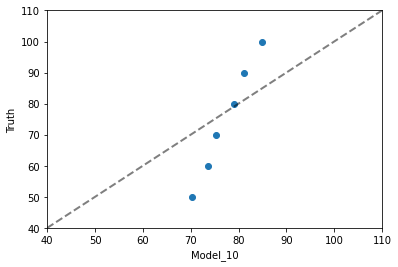

In [ ]:
plt.scatter(model10_theta,[50,60,70,80,90,100])
plt.xlabel("Model_10")
plt.ylabel("Truth")
plt.xlim(40,110)
plt.ylim(40,110)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


In [ ]:
#I people, J questions

model_stevenslaw_code = """
data {
  int<lower=0> I; //Number of people
  int<lower=0> J; //Number of questions
  matrix<lower=0>[I,J] y; //stimulus intensity
  matrix<lower=0>[I,J] d; //sensation magnitude
  real U;
}
parameters{
  real<lower=0> psisq; 
  real<lower=0> k;
  real<lower=0> alpha;

}
transformed parameters{
  real<lower=0> psi;
  matrix<lower=0>[I,J] nu;
  matrix<lower=0>[I,J] mu;
  for(i in 1:I)
    for(j in 1:J)
      nu[i,j] = pow(d[i,j],alpha);
  mu = k*nu;
  psi = sqrt(psisq);
}
model{
  psisq ~ inv_gamma(1,1);
  alpha ~ normal(.5,1);
  k ~ normal(10,10);
  for(i in 1:I)
    for(j in 1:J)
      y[i,j] ~ normal(mu[i,j], psi);
}
"""


In [ ]:
data_model_stl= {"I":I, "J":J, "y":y.values.reshape(I,J), "d":theta.values.reshape(I,J), "U":0}
model_stl = pystan.StanModel(model_code=model_stevenslaw_code)
fit_model_stl = model_stl.sampling(data=data_model_stl, chains=4, seed=111)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_13509a220e1e6eb443dbee731243b0a9 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
#I people, J questions

model_stevenslaw_code_hierarchical = """
data {
  int<lower=0> I; //Number of people
  int<lower=0> J; //Number of questions
  matrix<lower=0>[I,J] y; //stimulus intensity
  matrix<lower=0>[I,J] d; //sensation magnitude
  real U;
}
parameters{
  real<lower=0> psisq; 
  real<lower=0> k;
  real<lower=0> alpha;
  real<lower=0> mu_alpha;
  real<lower=0> mu_k;

}
transformed parameters{
  real<lower=0> psi;
  matrix<lower=0>[I,J] nu;
  matrix<lower=0>[I,J] mu;
  for(i in 1:I)
    for(j in 1:J)
      nu[i,j] = pow(d[i,j],alpha);
  mu = k*nu;
  psi = sqrt(psisq);
}
model{
  psisq ~ inv_gamma(1,1);
  alpha ~ normal(mu_alpha,1);
  k ~ normal(mu_k,10);
  mu_alpha ~ normal(.5,1);
  mu_k ~ normal(10,10);
  for(i in 1:I)
    for(j in 1:J)
      y[i,j] ~ normal(mu[i,j], psi);
}
"""


In [ ]:
data_model_stl= {"I":I, "J":J, "y":y.values.reshape(I,J), "d":theta.values.reshape(I,J), "U":0}
model_stl = pystan.StanModel(model_code=model_stevenslaw_code_hierarchical)
fit_model_stl = model_stl.sampling(data=data_model_stl, chains=4, seed=111)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_504382a078aaa0f39f760cc8b48f7338 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
#per person k 
model_sl1_code = """
data {
  int<lower=0> I; //Number of people
  int<lower=0> N; 
  vector<lower=0>[N] y; //sensation magnitude
  real U;
}
parameters{
  real<lower=0> psisq; 
  real<lower=0> k;
  real<lower=0> alpha;
  real<lower=0> theta;

}
transformed parameters{
  real<lower=0> psi;
  real<lower=0> mu;
  real<lower=0> nu;
  nu = pow(theta,alpha);
  mu= k*nu;
  psi = sqrt(psisq);
}
model{
  theta ~ normal(75,25);
  psisq ~ inv_gamma(1,1);
  alpha ~ normal(.9,.1);
  k ~ normal(1.5,.25);
  y ~ normal(mu, psi);
}
"""

In [ ]:
for value in [50,60,70,80,90,100]:
  print(y[theta==value].mean())

42.885714285714286
50.68888888888889
56.73968253968254
64.03809523809524
70.33174603174604
78.55714285714286


In [ ]:
# .values.reshape(I,10)
mean_estimate_theta = []
for value in [50,60,70,80,90,100]:
  data_model_sl1= {"I":I, "N":I*10,"y":y[theta==value], "U":0}
  model_sl1 = pystan.StanModel(model_code=model_sl1_code)
  fit_model_sl1 = model_sl1.sampling(data=data_model_sl1, chains=4, seed=111)
  # mean_estimate = [0]*I
  # for i in range(I):
    # mean_estimate = ((value)**mean_alpha)*fit_model_sl1[f'k[{i+1}]'].mean()
  mean_estimate_theta.append(fit_model_sl1['theta'].mean())
  print(f"theta: {value}, estimate:{np.mean(mean_estimate)}")


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf3b4be72520ffc9f5b0e1338e2131e6 NOW.


NameError: ignored

In [ ]:
mean_estimate_theta = []
k_estimate = [0]*I
for i in range(I):
  k_estimate[i] = fit_model_sl1[f'k[{i+1}]'].mean()
plt.hist(k_estimate)

In [ ]:
plt.scatter(mean_estimate_theta,[50,60,70,80,90,100])
plt.xlabel("SL1")
plt.ylabel("Truth")
plt.xlim(30,120)
plt.ylim(30,120)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


In [ ]:
#per person k , alpha
model_sl2_code = """
data {
  int<lower=0> I; //Number of people
  matrix<lower=0>[I,10] y; //sensation magnitude
  real U;
}
parameters{
  real<lower=0> psisq; 
  vector<lower=0>[I] k;
  vector<lower=0>[I] alpha;
  real<lower=0> theta;

}
transformed parameters{
  real<lower=0> psi;
  vector<lower=0>[I] nu;
  vector<lower=0>[I] mu;
  for(i in 1:I)
    nu[i] = pow(theta,alpha[i]);
  for(i in 1:I)
    mu[i] = k[i]*nu[i];
    
  psi = sqrt(psisq);
}
model{
  theta ~ normal(75,25);
  psisq ~ inv_gamma(1,1);
  alpha ~ normal(.9,.1);
  k ~ normal(1.5,.25);
  for(i in 1:I)
    y[i] ~ normal(mu[i], psi);
}
"""

In [ ]:
mean_estimate_theta_sl2 = []
for value in [50,60,70,80,90,100]:
  data_model_sl2= {"I":I, "y":y[theta==value].values.reshape(I,10), "U":0}
  model_sl2 = pystan.StanModel(model_code=model_sl2_code)
  fit_model_sl2 = model_sl2.sampling(data=data_model_sl2, chains=4, seed=111)
  mean_estimate = fit_model_sl2['theta'].mean()
  mean_estimate_theta_sl2.append(mean_estimate)
  print(f"theta: {value}, estimate:{mean_estimate}")


In [ ]:
plt.scatter(mean_estimate_theta_sl2,[50,60,70,80,90,100], label='model: stevens law')
plt.scatter(mean_response,[50,60,70,80,90,100], label = 'mean')
plt.xlabel('Estimated')
plt.ylabel("Truth")
plt.xlim(30,110)
plt.ylim(30,110)
plt.legend()
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)


In [ ]:
#per person k , alpha
model_sl2_hierarchical_code = """
data {
  int<lower=0> I; //Number of people
  matrix<lower=0>[I,10] y; //sensation magnitude
  real U;
  real L;
}
parameters{
  real<lower=0> psisq; 
  real<lower=0> mu_alpha; 
  real<lower=0> mu_k; 
  vector<lower=0>[I] k;
  vector<lower=0>[I] alpha;
  real<lower=0> theta;

}
transformed parameters{
  real<lower=0> psi;
  vector<lower=0>[I] nu;
  vector<lower=0>[I] mu;
  for(i in 1:I)
    nu[i] = pow(theta,alpha[i]);
  for(i in 1:I)
    mu[i] = k[i]*nu[i];    
  psi = sqrt(psisq);
}
model{
  theta ~ normal(75,25);
  psisq ~ inv_gamma(1,1);
  alpha ~ normal(mu_alpha,.1);
  mu_alpha ~ normal(.9,.2) T[L,U];
  k ~ normal(mu_k,.2);
  mu_k ~ normal(1.5, .3) T[L,U];
  for(i in 1:I)
    y[i] ~ normal(mu[i], psi);
}
"""

In [ ]:
mean_estimate_theta_sl2_hierarchical = []
for value in [50,60,70,80,90,100]:
  data_model_sl2_hierarchical= {"I":I, "y":y[theta==value].values.reshape(I,10), "U":1000, "L":0}
  model_sl2_hierarchical = pystan.StanModel(model_code=model_sl2_hierarchical_code)
  fit_model_sl2_hierarchical = model_sl2_hierarchical.sampling(data=data_model_sl2_hierarchical, chains=4, seed=111)
  mean_estimate = fit_model_sl2_hierarchical['theta'].mean()
  mean_estimate_theta_sl2_hierarchical.append(mean_estimate)
  print(f"theta: {value}, estimate:{mean_estimate}")


In [ ]:
plt.scatter(mean_estimate_theta_sl2_hierarchical,[50,60,70,80,90,100], label='model: SL hierachical')
plt.scatter(mean_response,[50,60,70,80,90,100], label = 'mean')
plt.xlabel('Estimated')
plt.ylabel("Truth")
plt.xlim(30,110)
plt.ylim(30,110)
plt.legend()
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False, alpha = .5)
